# Diffusion on an Exponentially Tilted Uniform Measure on a Line

In this notebook we:

1. Start with a uniform variable \(t\) on \([0,1]\) (with mean 0.5) and define a linear mapping
   \[
     f(t) = (t, 2t-1)
   \]
   so that the data lie on a straight line in the \(xy\)-plane.

2. Compute an exponentially tilted measure of \(t\) with density
   \[
     p_\theta(t) \propto \exp(\theta\,t)
   \]
   and use binary search to find \(\theta\) that gives a new mean (e.g. 0.7).

3. Use rejection sampling to generate samples from the tilted measure.

4. Map these samples through \(f(t)\) to obtain 2D points.

5. Train a diffusion model on these data and generate samples via the analytical method, DDIM, and DDPM.


## 1. Setup: Imports and Helper Functions

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

# Set a device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## 2. Define the Linear Mapping \(f(t)\)

In [3]:
def f(t):
    return np.stack([10*(t - 0.5), 10*(t - 0.5)], axis=1)
    t = np.power(t, 0.7)
    t = np.pi * (3 * t + 1)

    x = t * np.cos(t)
    y = t * np.sin(t)
    data = np.stack([x, y], axis=1)
    return data

## 3. Generate Uniform Samples and Plot

We first generate samples of \(t\) from a uniform distribution (mean 0.5) and map them using \(f(t)\).

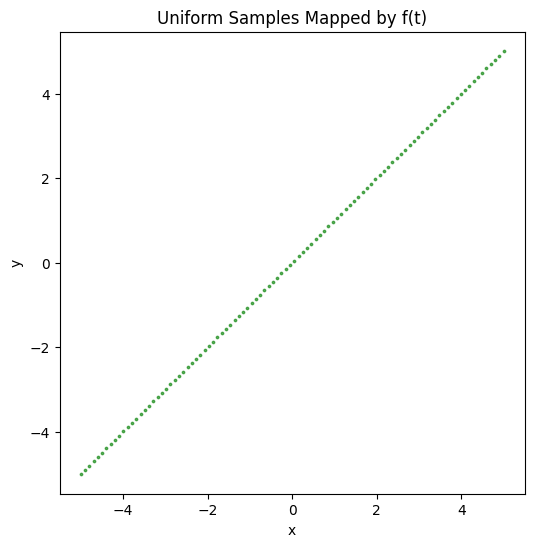

In [4]:
n_samples = 100
t_uniform = np.linspace(0, 1, n_samples)
data_uniform = f(t_uniform)

plt.figure(figsize=(6, 6))
plt.scatter(data_uniform[:, 0], data_uniform[:, 1], s=3, color="green", alpha=0.6)
plt.title("Uniform Samples Mapped by f(t)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

## 4. Exponential Tilting of the Measure

We wish to tilt the uniform distribution so that the new mean is, say, 0.7. For a density

$
p_\theta(t) \propto \exp(\theta\, t), \quad t\in[0,1]
$

We then use a binary search to find the value of $\theta$.

In [5]:
def weighted_mean(theta, t):
    weights = np.exp(theta * t)
    return np.sum(t * weights) / np.sum(weights)


def find_theta(target_mean, t, tol=1e-10, max_iter=100):
    low, high = -10, 10.0  # search interval
    for i in range(max_iter):
        mid = (low + high) / 2
        m = weighted_mean(mid, t)
        if abs(m - target_mean) < tol:
            return mid
        elif m < target_mean:
            low = mid
        else:
            high = mid
    return mid


theta_target = find_theta(0.7, t_uniform)
print(
    f"Found theta: {theta_target:.6f}, which gives mean = {weighted_mean(theta_target, t_uniform):.6f}"
)

Found theta: 2.613027, which gives mean = 0.700000


## 5. Rejection Sampling from the Tilted Measure

Our target density is

$
p(t) = \frac{\exp(\theta t)}{Z(\theta)}
$

with $Z(\theta)$ as above. Using a uniform proposal on $[0,1]$, the maximum of the density occurs at $t=1$, so the rejection constant is

$
M = \frac{\exp(\theta)}{Z(\theta)}
$

A candidate $t$ is accepted with probability

$
\frac{p(t)}{M\cdot 1} = \frac{\exp(\theta t)/Z(\theta)}{\exp(\theta)/Z(\theta)} = \exp\big(\theta(t-1)\big)
$

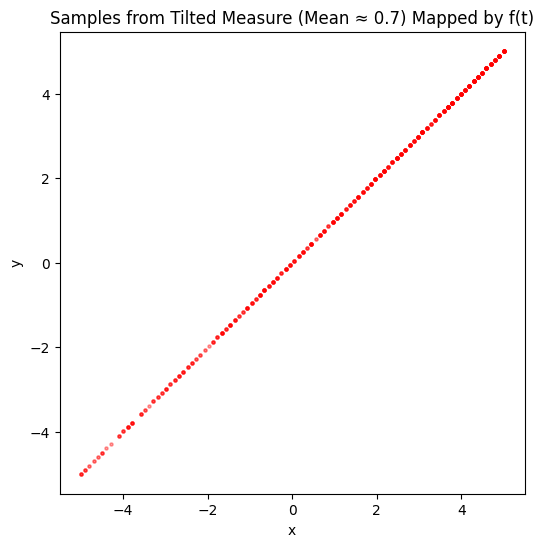

In [6]:
def sample_tilted(n_samples, theta, base_points):
    samples = []
    while len(samples) < n_samples:
        t_candidate = np.random.choice(base_points)  # choose from the fixed grid
        acceptance_prob = np.exp(theta * (t_candidate - 1))
        if np.random.rand() < acceptance_prob:
            samples.append(t_candidate)
    return np.array(samples)

t_tilted = sample_tilted(1000, 1.7, t_uniform)
data_tilted = f(t_tilted)

plt.figure(figsize=(6, 6))
plt.scatter(data_tilted[:, 0], data_tilted[:, 1], s=5, color="red", alpha=0.2)
plt.title("Samples from Tilted Measure (Mean ≈ 0.7) Mapped by f(t)")
plt.xlabel("x")
plt.ylabel("y")
plt.axis("equal")
plt.show()

## 6. Diffusion Experiments on the Tilted Data

We now train a diffusion model on the tilted data and generate samples using three methods:

- **Analytical Sampling**: Using a kernel–based conditional expectation.
- **DDIM Sampling**
- **DDPM Sampling**

First, we define the necessary diffusion parameters and a simple diffusion model.

### 6.1 Diffusion Utilities

In [7]:
def get_diffusion_params(T, device):
    betas = np.linspace(1e-4, 0.1, T)  # linear schedule
    alphas = 1 - betas
    alpha_bars = np.cumprod(alphas)
    betas = torch.tensor(betas, dtype=torch.float32, device=device)
    alphas = torch.tensor(alphas, dtype=torch.float32, device=device)
    alpha_bars = torch.tensor(alpha_bars, dtype=torch.float32, device=device)
    return betas, alphas, alpha_bars


class DiffusionModel(nn.Module):
    def __init__(self, time_embedding_dim=32, hidden_dim=128, num_layers=8):
        super().__init__()
        self.time_embedding = nn.Sequential(
            nn.Linear(1, time_embedding_dim),
            nn.ReLU(),
            nn.Linear(time_embedding_dim, time_embedding_dim),
        )
        layers = [nn.Linear(2 + time_embedding_dim, hidden_dim), nn.ReLU()]
        for _ in range(num_layers):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, 2))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        t_emb = self.time_embedding(t)
        x_input = torch.cat([x, t_emb], dim=1)
        return self.net(x_input)

### 6.2 Training the Diffusion Model on the Tilted Data

We use the tilted data (already mapped to 2D by \(f\)) as the training set.

In [8]:
def train_model_on_line(
    data, num_epochs=1000, T=100, batch_size=128, device=device, print_every=200
):
    data_tensor = torch.tensor(data, dtype=torch.float32)
    dataset = TensorDataset(data_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    model = DiffusionModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    total_epochs = num_epochs * T
    print_every = print_every * T

    model.train()
    for epoch in range(1, total_epochs + 1):
        total_loss = 0
        for (x0,) in dataloader:
            x0 = x0.to(device)
            B = x0.shape[0]
            # Sample a random time index for each sample
            t = torch.randint(0, T, (B,), device=device)
            noise = torch.randn_like(x0)
            sqrt_alpha_bar = torch.sqrt(alpha_bars[t]).unsqueeze(1)
            sqrt_one_minus_alpha_bar = torch.sqrt(1 - alpha_bars[t]).unsqueeze(1)
            x_t = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
            t_norm = (t.float() / T).unsqueeze(1)
            noise_pred = model(x_t, t_norm)
            loss = ((noise_pred - noise) ** 2).mean()
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if epoch % print_every == 0 or epoch == 1:
            print(f"Epoch {epoch // T}/{num_epochs}, Loss: {loss.item():.4f}")
    return model, betas, alphas, alpha_bars

### 6.3 Sampling Functions: DDPM, DDIM, and Analytical Sampling

These functions generate a sequence of samples (trajectories) through the reverse process.

In [9]:
@torch.no_grad()
def sample_ddpm(model, num_samples, T, betas, alphas, alpha_bars, device=device):
    model.eval()
    x = torch.randn(num_samples, 2, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        t_tensor = torch.full((num_samples, 1), t / T, device=device)
        eps = model(x, t_tensor)
        beta_t = betas[t]
        alpha_t = alphas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev = alpha_bars[t - 1]
        z = torch.randn_like(x)
        x0 = (1 / torch.sqrt(alpha_bar_t)) * (x - (torch.sqrt(1 - alpha_bar_t) * eps))
        mu = (torch.sqrt(alpha_t) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * x + (
            torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t)
        ) * x0
        noise = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * z
        x = mu + noise
        samples.append(x.cpu().numpy())
    return np.array(samples)


@torch.no_grad()
def sample_ddim(model, num_samples, T, alpha_bars, device=device):
    model.eval()
    x = torch.randn(num_samples, 2, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        t_tensor = torch.full((num_samples, 1), t / T, device=device)
        eps = model(x, t_tensor)
        alpha_bar_t = alpha_bars[t]
        sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)
        x0_pred = (x - sqrt_one_minus_alpha_bar_t * eps) / sqrt_alpha_bar_t
        alpha_bar_prev = alpha_bars[t - 1]
        sqrt_alpha_bar_prev = torch.sqrt(alpha_bar_prev)
        sqrt_one_minus_alpha_bar_prev = torch.sqrt(1 - alpha_bar_prev)
        x = sqrt_alpha_bar_prev * x0_pred + sqrt_one_minus_alpha_bar_prev * eps
        samples.append(x.cpu().numpy())
    return np.array(samples)


def compute_E_x_given_y_vectorized(x_points, sigma, grid_points):
    diff = grid_points[:, None, :] - x_points[None, :, :]
    distances_sq = np.sum(diff**2, axis=2)
    exponent = -distances_sq / (2 * sigma**2)

    # Subtract maximum exponent in each row for stability
    max_exponent = np.max(exponent, axis=1, keepdims=True)
    weights = np.exp(exponent - max_exponent)
    numerator = weights @ x_points
    denominator = np.sum(weights, axis=1, keepdims=True)

    # Add a small epsilon to denominator to avoid division by zero.
    return numerator / (denominator + 1e-12)


@torch.no_grad()
def sample_analytically(x_points, grid_points, T, device=device):
    betas, alphas, alpha_bars = get_diffusion_params(T, device)
    x = torch.tensor(grid_points, dtype=torch.float32, device=device)
    samples = [x.cpu().numpy()]
    for t in reversed(range(1, T)):
        beta_t = betas[t]
        alpha_bar_t = alpha_bars[t]
        alpha_bar_prev = alpha_bars[t - 1]
        sigma = torch.sqrt(beta_t * (1 - alpha_bar_prev) / (1 - alpha_bar_t)).item()
        x_np = x.cpu().numpy()
        x0_np = compute_E_x_given_y_vectorized(x_points, sigma, x_np)
        x0 = torch.tensor(x0_np, dtype=torch.float32, device=device)
        mu = (torch.sqrt(alphas[t]) * (1 - alpha_bar_prev) / (1 - alpha_bar_t)) * x + (
            torch.sqrt(alpha_bar_prev) * beta_t / (1 - alpha_bar_t)
        ) * x0
        z = torch.randn_like(x)
        x = mu + sigma * z
        samples.append(x.cpu().numpy())
    return np.array(samples)

### 6.4 Combined Figure: Comparing the Data and Sampling Methods

This function trains the diffusion model on the tilted data and then plots:

- The tilted data itself.
- A few sample trajectories from the analytical method.
- Trajectories from DDIM.
- Trajectories from DDPM.

In [10]:
def create_combined_figure_line(
    data_tilted,
    num_samples=50,
    T_an=100,
    T_nn=100,
    num_epochs=1000,
    batch_size=128,
    grid_points=10,
    interval=50,
    print_every=200,
    device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
):
    """
    Trains a diffusion model on the tilted data and produces a single animation with 4 subplots:
      - Top-left: static plot (scatter) of the tilted samples.
      - Top-right: animation for analytical sampling.
      - Bottom-left: animation for DDIM sampling.
      - Bottom-right: animation for DDPM sampling.

    Returns:
      An HTML object containing the animation.
    """
    # --- Train Diffusion Model on Tilted Data ---
    model, betas, alphas, alpha_bars = train_model_on_line(
        data_tilted, num_epochs=num_epochs, T=T_nn, batch_size=batch_size, device=device, print_every=print_every
    )

    # Determine axis limits for all subplots (add some margin)
    xy_max = 6
    xy_min = -xy_max

    linspace = np.linspace(xy_min, xy_max, grid_points)
    grid_points = np.meshgrid(linspace, linspace)
    grid_points = np.column_stack([grid_points[0].ravel(), grid_points[1].ravel()])

    # --- Generate Sampling Trajectories ---
    samples_analytical = sample_analytically(data_tilted, grid_points, T_an, device)
    samples_ddim = sample_ddim(model, num_samples, T_nn, alpha_bars, device)
    samples_ddpm = sample_ddpm(model, num_samples, T_nn, betas, alphas, alpha_bars, device)

    # --- Create Figure with 4 Subplots ---
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    plt.tight_layout(pad=3, h_pad=3, w_pad=3)

    # Top-left: Static plot of tilted samples
    ax_static = axes[0, 0]
    ax_static.scatter(data_tilted[:, 0], data_tilted[:, 1], s=5, color="red")
    ax_static.set_title("Tilted Samples (Line)")
    ax_static.set_xlim(xy_min, xy_max)
    ax_static.set_ylim(xy_min, xy_max)

    # Top-right: Analytical sampling animation
    ax_analytical = axes[0, 1]
    ax_analytical.set_title("Analytical Sampling Animation")
    ax_analytical.set_xlim(xy_min, xy_max)
    ax_analytical.set_ylim(xy_min, xy_max)

    # Bottom-left: DDIM sampling animation
    ax_ddim = axes[1, 0]
    ax_ddim.set_title("DDIM Sampling Animation")
    ax_ddim.set_xlim(xy_min, xy_max)
    ax_ddim.set_ylim(xy_min, xy_max)

    # Bottom-right: DDPM sampling animation
    ax_ddpm = axes[1, 1]
    ax_ddpm.set_title("DDPM Sampling Animation")
    ax_ddpm.set_xlim(xy_min, xy_max)
    ax_ddpm.set_ylim(xy_min, xy_max)

    # Initialize empty scatter plots for the animated subplots
    scatter_analytical = ax_analytical.scatter([], [], s=2, color="blue")
    scatter_ddim = ax_ddim.scatter([], [], s=2, color="green")
    scatter_ddpm = ax_ddpm.scatter([], [], s=2, color="purple")

    # Determine the number of frames (assuming all sampling trajectories have the same length)
    num_frames = len(samples_ddpm)

    # --- Update function for animation ---
    def update(frame):
        # Update analytical sampling
        a_frame = min(frame, len(samples_analytical) - 1)
        data_a = samples_analytical[a_frame]
        scatter_analytical.set_offsets(data_a)

        # Update DDIM sampling
        data_d = samples_ddim[frame]
        scatter_ddim.set_offsets(data_d)

        # Update DDPM sampling
        data_p = samples_ddpm[frame]
        scatter_ddpm.set_offsets(data_p)

        # Return the updated scatter objects
        return scatter_analytical, scatter_ddim, scatter_ddpm

    anim = FuncAnimation(fig, update, frames=num_frames, interval=interval, blit=True)

    # Print the mean x-coordinate of the samples using the 3 methods
    mean_ddim = np.mean(samples_ddim[-1][:, 0])
    mean_ddpm = np.mean(samples_ddpm[-1][:, 0])
    valid_indices = ~np.isnan(samples_analytical[-1][:, 0])
    mean_analytical = np.mean(samples_analytical[-1][valid_indices, 0])
    mean_data = np.mean(data_tilted[:, 0])
    
    print(f"Mean x-coordinate (Data): {mean_data:.4f}")
    print(f"Mean x-coordinate (Analytical): {mean_analytical:.4f}")
    print(f"Mean x-coordinate (DDIM): {mean_ddim:.4f}")
    print(f"Mean x-coordinate (DDPM): {mean_ddpm:.4f}")

    # Convert animation to HTML5 video and close the figure
    html_anim = anim.to_html5_video()
    plt.close(fig)

    return HTML(html_anim)

## 7. Run the Combined Experiment

Finally, we call the combined function. (You can adjust parameters such as the number of epochs, diffusion timesteps \(T\), and number of trajectories to plot.)

In [11]:
num_points = 2048
batch_size = 512

num_samples = 5000
grid_points = 15
T_an = 30
T_nn = 200
epochs = 30
interval = 20
print_every = 5

t_uniform = np.linspace(0, 1, num_points)
theta_target = find_theta(0.5, t_uniform)
t_tilted = sample_tilted(num_points, theta_target, t_uniform)
data_tilted = f(t_tilted)

html_output = create_combined_figure_line(
    data_tilted,
    num_samples=num_samples,
    T_an=T_an,
    T_nn=T_nn,
    num_epochs=epochs,
    batch_size=batch_size,
    interval=interval,
    print_every=print_every,
    grid_points=grid_points,
)

print(f"Theta: {theta_target:.6f}")
display(html_output)

Epoch 0/30, Loss: 0.9838
Epoch 5/30, Loss: 0.2537
Epoch 10/30, Loss: 0.2439
Epoch 15/30, Loss: 0.2474
Epoch 20/30, Loss: 0.2645
Epoch 25/30, Loss: 0.2760
Epoch 30/30, Loss: 0.2436
Mean x-coordinate (Data): 0.0820
Mean x-coordinate (Analytical): 0.1509
Mean x-coordinate (DDIM): 0.1322
Mean x-coordinate (DDPM): 0.0928
Theta: 0.000000


In [12]:
theta_target = find_theta(0.8, t_uniform)
t_tilted = sample_tilted(num_points, theta_target, t_uniform)
data_tilted = f(t_tilted)

html_output = create_combined_figure_line(
    data_tilted,
    num_samples=num_samples,
    T_an=T_an,
    T_nn=T_nn,
    num_epochs=epochs,
    batch_size=batch_size,
    interval=interval,
    print_every=print_every,
    grid_points=grid_points,
)

print(f"Theta: {theta_target:.6f}")
display(html_output)

Epoch 0/30, Loss: 1.0472
Epoch 5/30, Loss: 0.2142
Epoch 10/30, Loss: 0.1925
Epoch 15/30, Loss: 0.1941
Epoch 20/30, Loss: 0.2381
Epoch 25/30, Loss: 0.1703
Epoch 30/30, Loss: 0.2207
Mean x-coordinate (Data): 3.0276
Mean x-coordinate (Analytical): 0.0956
Mean x-coordinate (DDIM): 2.8357
Mean x-coordinate (DDPM): 2.8030
Theta: 4.794488
